# Using Multivariate Gaussian NGBoost (MVN NGBoost)

This notebook outlines using MVN NGBoost for predicting response vectors for simulated and real world data. This notebook draws upon [O'Malley et al. 2023](https://www.cambridge.org/core/journals/environmental-data-science/article/probabilistic-prediction-of-oceanographic-velocities-with-multivariate-gaussian-natural-gradient-boosting/F26F2BD51213758208B0EBAE51D1A973#article) and the supplementary materials they have provided.

In [73]:
# import packages
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('models'), '..')))
import pandas as pd
import ngboost
import numpy as np
from seaducks.models._mvn_ngboost import MVN_ngboost
import scipy.stats as stats
import matplotlib.pyplot as plt

# configure plots
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

plt.style.use('ggplot')

# Simulated Example

In this example, following the work of O'Malley et al. (2023), we generate synthetic data according to: 

$$\begin{aligned}
\mathbf{X}_{i} & \stackrel{\text { IID }}{\sim} \text { Uniform }(0, \pi) \\
\mathbf{Y}_{i} \mid \mathbf{X}_{i} & \sim \mathbb{N}\left(\left[\begin{array}{l}
\mu_{1}\left(\mathbf{X}_{i}\right) \\
\mu_{2}\left(\mathbf{X}_{i}\right)
\end{array}\right],\left[\begin{array}{cc}
\sigma_{1}^{2}\left(\mathbf{X}_{i}\right) & \sigma_{1}\left(\mathbf{X}_{i}\right) \sigma_{2}\left(\mathbf{X}_{i}\right) \rho\left(\mathbf{X}_{i}\right) \\
\sigma_{1}\left(\mathbf{X}_{i}\right) \sigma_{2}\left(\mathbf{X}_{i}\right) \rho\left(\mathbf{X}_{i}\right) & \sigma_{2}^{2}\left(\mathbf{X}_{i}\right),
\end{array}\right]\right)
\end{aligned}$$

where

$$
\begin{aligned}
\mu_{1}(x) & =\sin (2.5 x) \sin (1.5 x)+x, \\
\mu_{2}(x) & =\cos (3.5 x) \cos (0.5 x)-x^{2}, \\
\sigma_{1}^{2}(x) & =0.01+0.25[1-\sin (2.5 x)]^{2}, \\
\sigma_{2}^{2}(x) & =0.01+0.25[1-\cos (3.5 x)]^{2}, \\
\rho(x) & =\sin (2.5 x) \cos (0.5 x) .
\end{aligned}
$$

In [30]:
def means(x,multiplier):
    return multiplier*np.sin(2.5*x)*np.sin(1.5*x) + x, multiplier*np.cos(3.5*x)*np.cos(0.5*x) - x**2

def variances(x,multiplier,additive):
    return additive + multiplier*(1-np.sin(2.5*x))**2, additive + multiplier*(1-np.cos(3.5*x))**2

def correlation(x):  
    return np.sin(2.5*x)*np.cos(0.5*x)

# -------------------------------------------------------- #

def covariance_matrix(x, multiplier, additive):
    var1,var2 = variances(x, multiplier, additive)
    cov = correlation(x)*np.sqrt(var1*var2)
    return [np.array([[var1_val, cov_val],[cov_val, var2_val]]) for var1_val, var2_val,cov_val in zip(var1,var2,cov)]

def mean_vector(x, multiplier):
    mean1,mean2 = means(x,multiplier)
    return [np.array([val1,val2]) for val1,val2 in zip(mean1,mean2)]

In [69]:
def simulate_data(N, sort=False, multiplier = 0.25, additive = 0.01):
    x = np.random.rand(N) * np.pi
    if sort:
        x = np.sort(x)
    mean = mean_vector(x,multiplier=multiplier)
    cov = covariance_matrix(x, multiplier=multiplier, additive=additive)
    dists = [stats.multivariate_normal(mean_val,cov_val) for mean_val,cov_val in zip(mean,cov)]
    y = np.array([dist.rvs(1) for dist in dists])

    return x.reshape(-1, 1) , y, dists
  

In [70]:
# simulate 5000 training and 500 validation data points
N_train = 5000
N_val = 500
max_boosting_iter = 1000
early_stopping_rounds = 50

X, Y, true_dist = simulate_data(N_train) # takes about 4s
X_val, Y_val, _ = simulate_data(N_val)

In [71]:
# initialise and fit mvn ngboost model
multivariate_ngboost = MVN_ngboost(n_estimators=max_boosting_iter,early_stopping_rounds=early_stopping_rounds)
multivariate_ngboost.fit(X,Y,X_val,Y_val)
pred_y_dist = multivariate_ngboost.pred_dist(X, max_iter=multivariate_ngboost.best_val_loss_itr)

[iter 0] loss=3.4727 val_loss=3.4996 scale=1.0000 norm=2.9875
[iter 100] loss=2.1222 val_loss=2.1361 scale=2.0000 norm=2.2928
[iter 200] loss=1.3249 val_loss=1.3436 scale=2.0000 norm=2.3476
[iter 300] loss=0.8683 val_loss=0.8983 scale=2.0000 norm=3.0924
[iter 400] loss=0.6720 val_loss=0.7354 scale=2.0000 norm=4.1822
[iter 500] loss=0.6210 val_loss=0.7146 scale=1.0000 norm=2.3861
== Early stopping achieved.
== Best iteration / VAL520 (val_loss=0.7142)


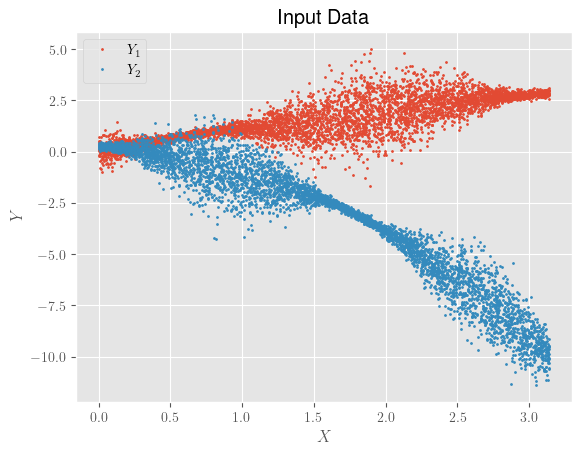

In [79]:
# plotting input data
fig, ax = plt.subplots()
ax.plot(X, Y[:, 0], "o", label="$Y_1$", markersize=1)
ax.plot(X, Y[:, 1], "o", label="$Y_2$",markersize=1)

# labelling
ax.set_xlabel("$X$")
ax.set_ylabel("$Y$")
ax.set_title("Input Data")
ax.legend()
plt.show()

In [115]:
# plot distributions
plot_x = [x[0] for x in X]
plot_x.sort()

# prediction summaries
ordered_indices = np.argsort(X.flatten())
mean = np.array([pred_y_dist.mean()[ii] for ii in ordered_indices])
cov = np.array([pred_y_dist.cov[ii] for ii in ordered_indices])
s11,s22, s12 = cov[:,0,0], cov[:,1,1], cov[:,0,1]

# true values
true_mean = np.array([true_dist[ii].mean for ii in ordered_indices])
true_cov = np.array([true_dist[ii].cov for ii in ordered_indices])
true_s11, true_s22, true_s12 = true_cov[:,0,0], true_cov[:,1,1], true_cov[:,0,1]


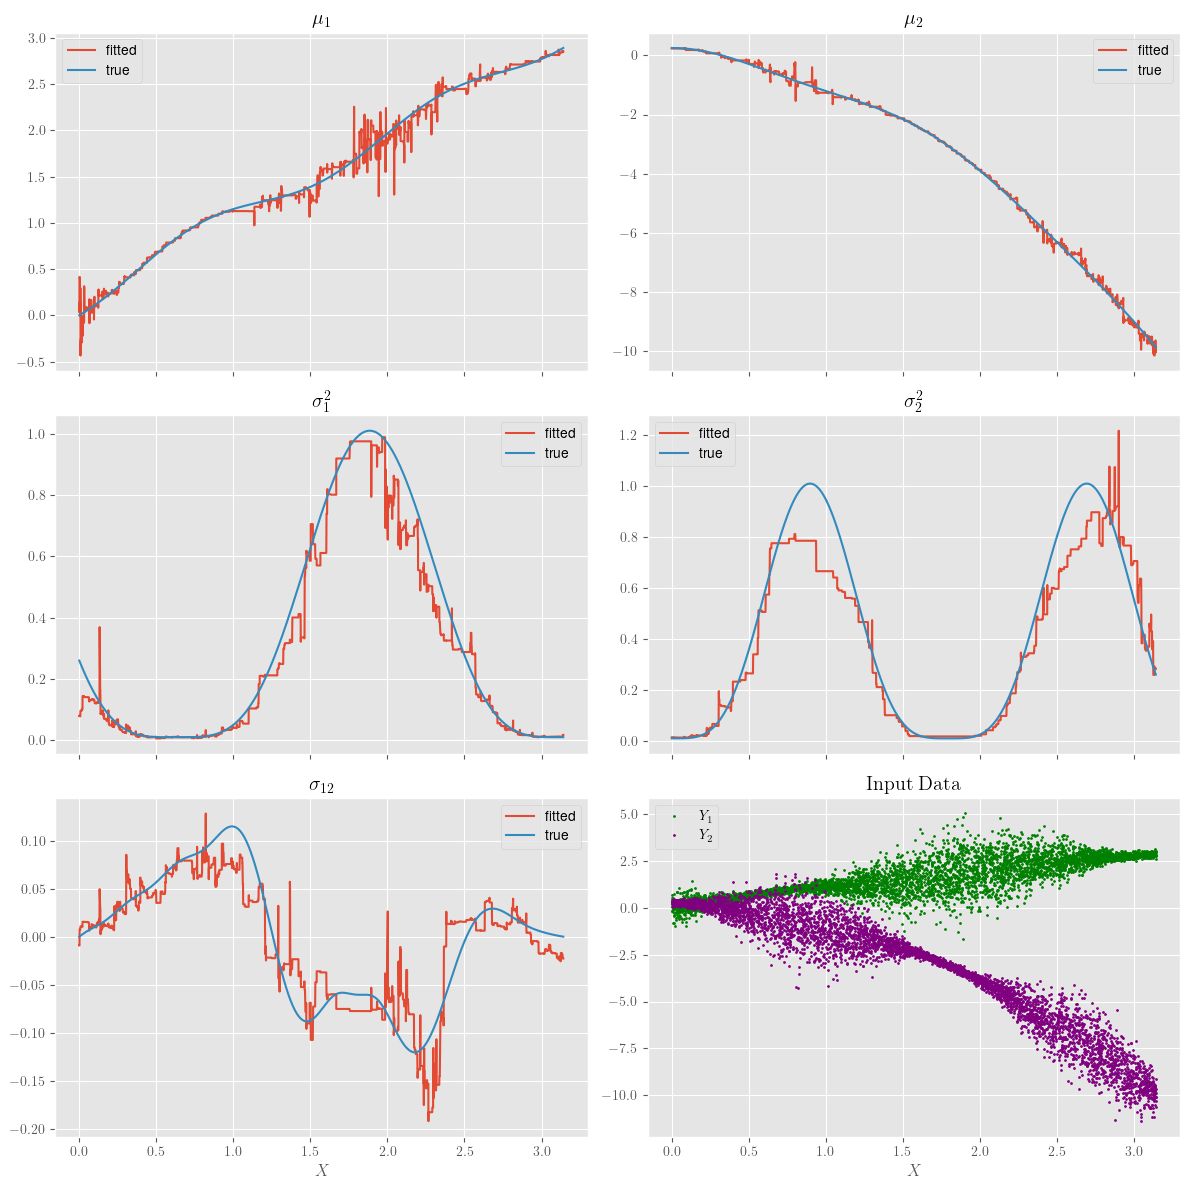

In [169]:
fig, ax = plt.subplots(3, 2, sharex=True, figsize = (12,12))
vars = [s11,s22]
true_vars = [true_s11,true_s22]

for ii in range(2):
    # set x labels
    ax[2,ii].set_xlabel('$X$')
    # set titles
    ax[0,ii].set_title(fr'$\mu_{ii+1}$')
    ax[1,ii].set_title(fr'$\sigma^2_{ii+1}$')
    # plot values
    ## mean
    ax[0,ii].plot(plot_x, mean[:,ii], label="fitted")
    ax[0,ii].plot(plot_x, true_mean[:,ii], label="true")
    ## variances
    ax[1,ii].plot(plot_x,vars[ii],label="fitted")
    ax[1,ii].plot(plot_x,true_vars[ii],label="true")

# set titles
ax[2,0].set_title(r'$\sigma_{12}$')
ax[2,1].set_title(r'$\mathrm{Input}$ $\mathrm{Data}$')

# plot values
ax[2,0].plot(plot_x, s12, label="fitted")
ax[2,0].plot(plot_x, true_s12, label="true")
ax[2,1].plot(X, Y[:, 0], "o", label="$Y_1$", markersize=1, c='green')
ax[2,1].plot(X, Y[:, 1], "o", label="$Y_2$",markersize=1, c='purple')

for ii in range(3):
    for jj in range(2):
        ax[ii,jj].legend()
        
fig.tight_layout()
plt.show()

# Drifter Velocity Prediction

In [3]:
# load data
path_to_data = r'..\seaducks\data\filtered_nao_drifters_with_sst_gradient.h5'
data = pd.read_hdf(path_to_data)
# add day of the year as an index (to be added to the data later)
data['day_of_year'] = data['time'].apply(lambda t : t.timetuple().tm_yday)

# separate into explanatory and response variables
explanatory_var_labels = ['u_av','v_av','lat','lon','day_of_year','Wx','Wy','Tx','Ty','sst_x_derivative','sst_y_derivative']
response_var_labels = ['u','v']

In [38]:
multivariate_ngboost = MVN_ngboost(n_estimators=25)

In [34]:
file_name = 'test'
multivariate_ngboost.run_model_and_save(data,explanatory_var_labels,response_var_labels,file_name)

[iter 0] loss=0.0487 val_loss=-0.0734 scale=0.5000 norm=1.5439


In [36]:
import pickle
with open('testtest_data.p', 'rb') as pickle_file:
    content = pickle.load(pickle_file)

In [37]:
import numpy as np

fi=multivariate_ngboost.feature_importances_
params = ['mu_x', 'mu_y', 'a_11', 'a_12','a_22']

for jj,param in enumerate(params):
    print(f'\nFeature Importances for {param}')
    for ii, var in enumerate(explanatory_var_labels):
        print(f"{var}: {fi[jj][ii]}")


Feature Importances for mu_x
u_av: 0.9630686644026271
v_av: 0.0
lat: 0.010718825286130815
lon: 0.0
day_of_year: 0.0
Wx: 0.0
Wy: 0.0
Tx: 0.0
Ty: 0.0
sst_x_derivative: 0.0
sst_y_derivative: 0.026212510311242217

Feature Importances for mu_y
u_av: 0.0
v_av: 0.9633852850700406
lat: 0.0
lon: 0.03661471492995927
day_of_year: 0.0
Wx: 0.0
Wy: 0.0
Tx: 0.0
Ty: 0.0
sst_x_derivative: 0.0
sst_y_derivative: 0.0

Feature Importances for a_11
u_av: 0.8943763743919959
v_av: 0.0
lat: 0.05246232160479388
lon: 0.01938576201026696
day_of_year: 0.0
Wx: 0.0
Wy: 0.0
Tx: 0.0
Ty: 0.0
sst_x_derivative: 0.0
sst_y_derivative: 0.03377554199294332

Feature Importances for a_12
u_av: 0.09031625171022113
v_av: 0.1437495608114901
lat: 0.5364111320251134
lon: 0.22363409628069744
day_of_year: 0.0
Wx: 0.0
Wy: 0.0
Tx: 0.0
Ty: 0.0
sst_x_derivative: 0.0035021544794677033
sst_y_derivative: 0.002386804693010288

Feature Importances for a_22
u_av: 0.0
v_av: 0.7402647521755785
lat: 0.007575646575885427
lon: 0.23271187075249303


In [28]:
multivariate_ngboost.best_val_loss_itr

9

In [ ]:
ngboost.NGBoost.feature_importances_

In [10]:
import numpy as np
predicted_distribution = content[1]
true_values = content[0]
locs, covs = predicted_distribution

np.sqrt(np.mean(np.square(np.array(true_values)-locs)))

0.23671849794720257

## Training, Cross-Validation, and Testing

To do:
* Explain what each of these terms mean and why we are doing them.
* Decide on the train-test-cross validation split
* Explain that this split must also apply for each drifter and explain why
* Include a sketch implementation of how this might be done.

## The MVN NGBoost Model

Include an explainer here as to how the model works.

In [ ]:
import ngboost.distns

multivariate_ngboost = ngboost.NGBoost(Dist=ngboost.distns.MultivariateNormal(2),n_estimators=15)
# fit the model
multivariate_ngboost.fit(X = explanatory_vars, Y = response_vars)

NameError: name 'explanatory_vars' is not defined

In [26]:
# get predictive distribution for each 
predicted_distribution = multivariate_ngboost.pred_dist(explanatory_vars)

In [27]:
import numpy as np

point_predictions = [point for point in predicted_distribution.loc]
np.sqrt(np.mean(np.square(np.array(response_vars)-point_predictions)))

0.23382208583662384